# Grid search for hyperparameter tunning 

# Import and setup


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import itertools
import os
import sys


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from mop_model import MoPModel as MoP_raw, MoPConfig


# Trainning and evaluation functions

In [96]:
def train_and_evaluate_trial_mop(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoP model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    config = MoPConfig(
        input_dim=X_train.shape[1],
        output_dim=2,
        intermediate_dim=params['intermediate_dim'],
        layers=params['layers']
    )
    model = MoP_raw(config).to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        # MoP expects a sequence dimension
        y_pred, usage_losses, entropy_loss = model(X_train_tensor.unsqueeze(1))
        y_pred = y_pred.squeeze(1)
        
        # MoP auxiliary losses can be added here for more robust training
        class_loss = criterion(y_pred, y_train_tensor)
        total_loss = class_loss 
        
        total_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, _, _ = model(X_val_tensor.unsqueeze(1))
            val_loss = criterion(y_val_pred.squeeze(1), y_val_tensor)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _, _ = model(X_val_tensor.unsqueeze(1))
        y_pred_tensor = y_pred_tensor.squeeze(1)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'intermediate_dim': params['intermediate_dim'],
            'layers': str(params['layers']), # Convert list to string for display
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


# Data Loading and Hyperparameter definition

In [97]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'uk_biobank_dataset.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False)
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_data.csv' not found. Please run the feature extractor first.")

# --- 2. Define the Hyperparameter Grid for MoP ---
param_grid = {
    'intermediate_dim': [32, 64, 96, 128],
    'layers': [
        ["0,8,16", "0,8,16", "0,8,16"],      # Three simple layers
        ["0,16,32", "0,16,32", "0,16,32"],    # Three more complex layers
        ["0,8,16", "0,16,32", "0,8,16"],      # A mix of simple and complex layers
        ["0,16,32", "0,8,16", "0,16,32"]       # Another mix
    ]
}

# Create all possible combinations
valid_params = [
    {'intermediate_dim': p[0], 'layers': p[1]}
    for p in itertools.product(param_grid['intermediate_dim'], param_grid['layers'])
]

print(f"\n🔹 Starting Grid Search for MoP. Total combinations to test: {len(valid_params)}")


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (926, 64)

🔹 Starting Grid Search for MoP. Total combinations to test: 16


# Run grid search and final evaluation

In [98]:

# --- 3. Run the Grid Search for MoP ---
results = []
for i, params in enumerate(valid_params):
    print(f"\n--- Testing Combination {i+1}/{len(valid_params)} ---")
    print(f"Parameters: {params}")
    
    result = train_and_evaluate_trial_mop(params, X_train_scaled, y_train.values, X_val_scaled, y_val.values)
    results.append(result)
    
    # Live update of results
    clear_output(wait=True)
    # --- Sort by validation accuracy ---
    results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
    print("✅ Intermediate Tuning Results for MoP (Validation Set):")
    display(results_df)

# --- 4. Final Evaluation on Test Set ---
print("\n\n" + "="*40 + "\n✅ FINAL MoP EVALUATION ON HELD-OUT TEST SET\n" + "="*40)

# Get the best parameters from the grid search
best_params = results_df.iloc[0].to_dict()
# --- Update print statement to reflect accuracy ---
print("🏆 Best MoP Hyperparameters found (based on validation Accuracy):")
print(f"  - Intermediate Dimension: {int(best_params['intermediate_dim'])}")
print(f"  - Layer Structure: {best_params['layers']}")

# Combine training and validation data
X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

print("\nRetraining the best MoP model on combined Train+Validation data...")

# Create the final model with the best parameters
final_config = MoPConfig(
    input_dim=X_train_val.shape[1],
    output_dim=2,
    intermediate_dim=int(best_params['intermediate_dim']),
    layers=eval(best_params['layers']) # Use eval to convert string back to list
)
final_model = MoP_raw(final_config)

# Train the final model and evaluate on the test set
final_results = train_and_evaluate_trial_mop(
    {'intermediate_dim': int(best_params['intermediate_dim']), 'layers': eval(best_params['layers'])},
    X_train_val, y_train_val, X_test_scaled, y_test.values
)

print("\n--- Final MoP Performance on Test Set ---")
print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
print(f"  - Precision:   {final_results['val_precision']:.4f}")
print(f"  - Recall:      {final_results['val_recall']:.4f}")
print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")


✅ Intermediate Tuning Results for MoP (Validation Set):


,intermediate_dim,layers,val_roc_auc,val_accuracy,val_f1_score,val_precision,val_recall,val_cohen_kappa
9,96,"['0,16,32', '0,16,32', '0,16,32']",0.813673,0.758099,0.760684,0.760684,0.760684,0.516142
1,32,"['0,16,32', '0,16,32', '0,16,32']",0.812955,0.753780,0.762500,0.743902,0.782051,0.507226
5,64,"['0,16,32', '0,16,32', '0,16,32']",0.814662,0.753780,0.760504,0.747934,0.773504,0.507318
11,96,"['0,16,32', '0,8,16', '0,16,32']",0.814905,0.753780,0.765432,0.738095,0.794872,0.507088
4,64,"['0,8,16', '0,8,16', '0,8,16']",0.811471,0.751620,0.762887,0.737052,0.790598,0.502787
8,96,"['0,8,16', '0,8,16', '0,8,16']",0.809764,0.745140,0.756198,0.732000,0.782051,0.489841
10,96,"['0,8,16', '0,16,32', '0,8,16']",0.809465,0.745140,0.756198,0.732000,0.782051,0.489841
0,32,"['0,8,16', '0,8,16', '0,8,16']",0.809232,0.742981,0.756646,0.725490,0.790598,0.485397
2,32,"['0,8,16', '0,16,32', '0,8,16']",0.814009,0.740821,0.755102,0.722656,0.790598,0.481048
15,128,"['0,16,32', '0,8,16', '0,16,32']",0.815931,0.740821,0.757085,0.719231,0.799145,0.480951




✅ FINAL MoP EVALUATION ON HELD-OUT TEST SET
🏆 Best MoP Hyperparameters found (based on validation Accuracy):
  - Intermediate Dimension: 96
  - Layer Structure: ['0,16,32', '0,16,32', '0,16,32']

Retraining the best MoP model on combined Train+Validation data...

--- Final MoP Performance on Test Set ---
  - Accuracy:    0.7500
  - ROC-AUC:     0.8139
  - F1-Score:    0.7553
  - Precision:   0.7490
  - Recall:      0.7617
  - Cohen Kappa: 0.4998




🚀 Starting SHAP Analysis

--- Analyzing Overall MoP Model ---

Generating side-by-side SHAP plots for the overall model...


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


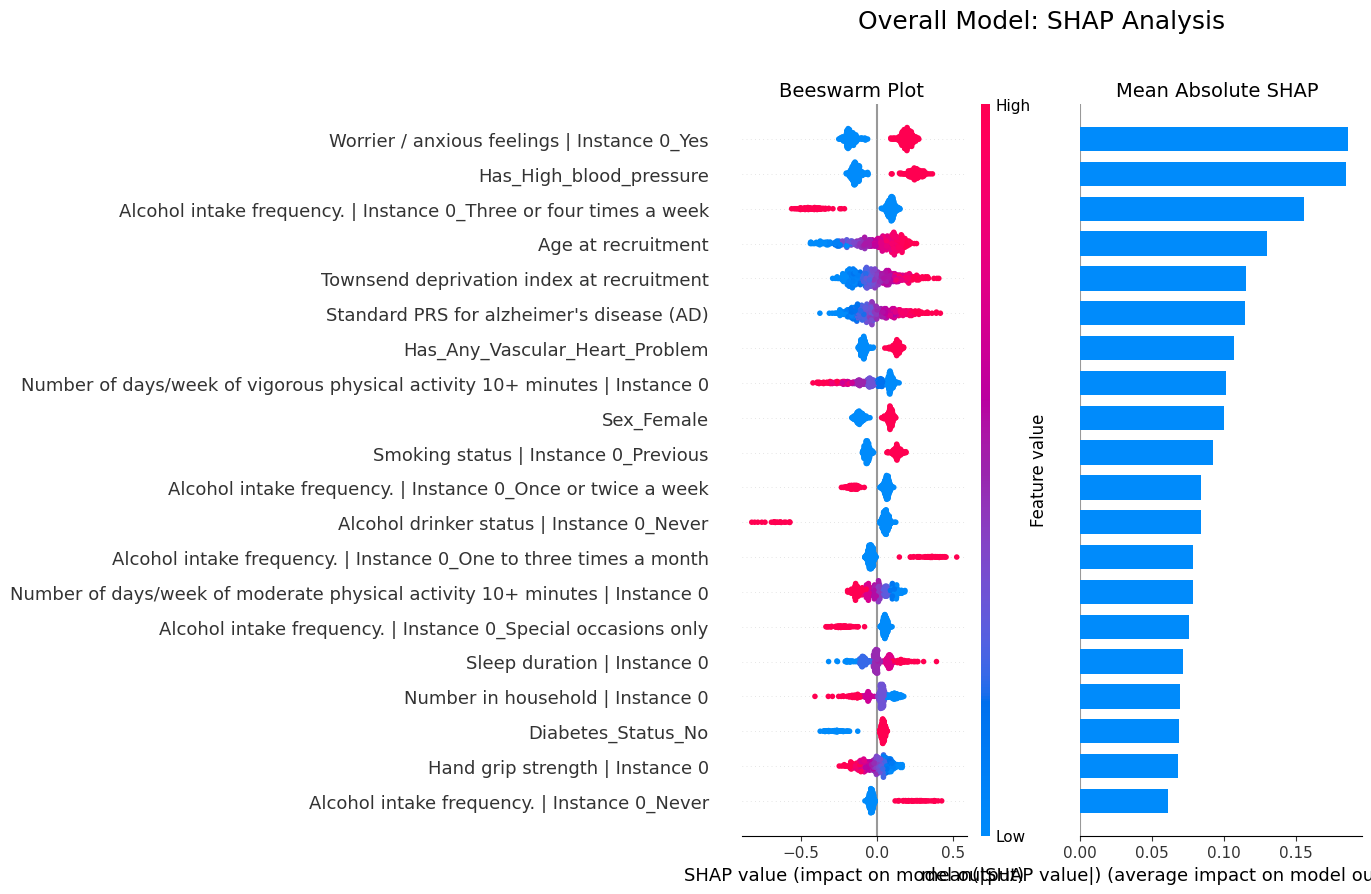



🕵️ Analyzing Expert Specializations

--- SHAP Analysis for 8 samples routed to Layer 1, Expert 2 ---
Generating side-by-side plots for Layer 1, Expert 2...


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


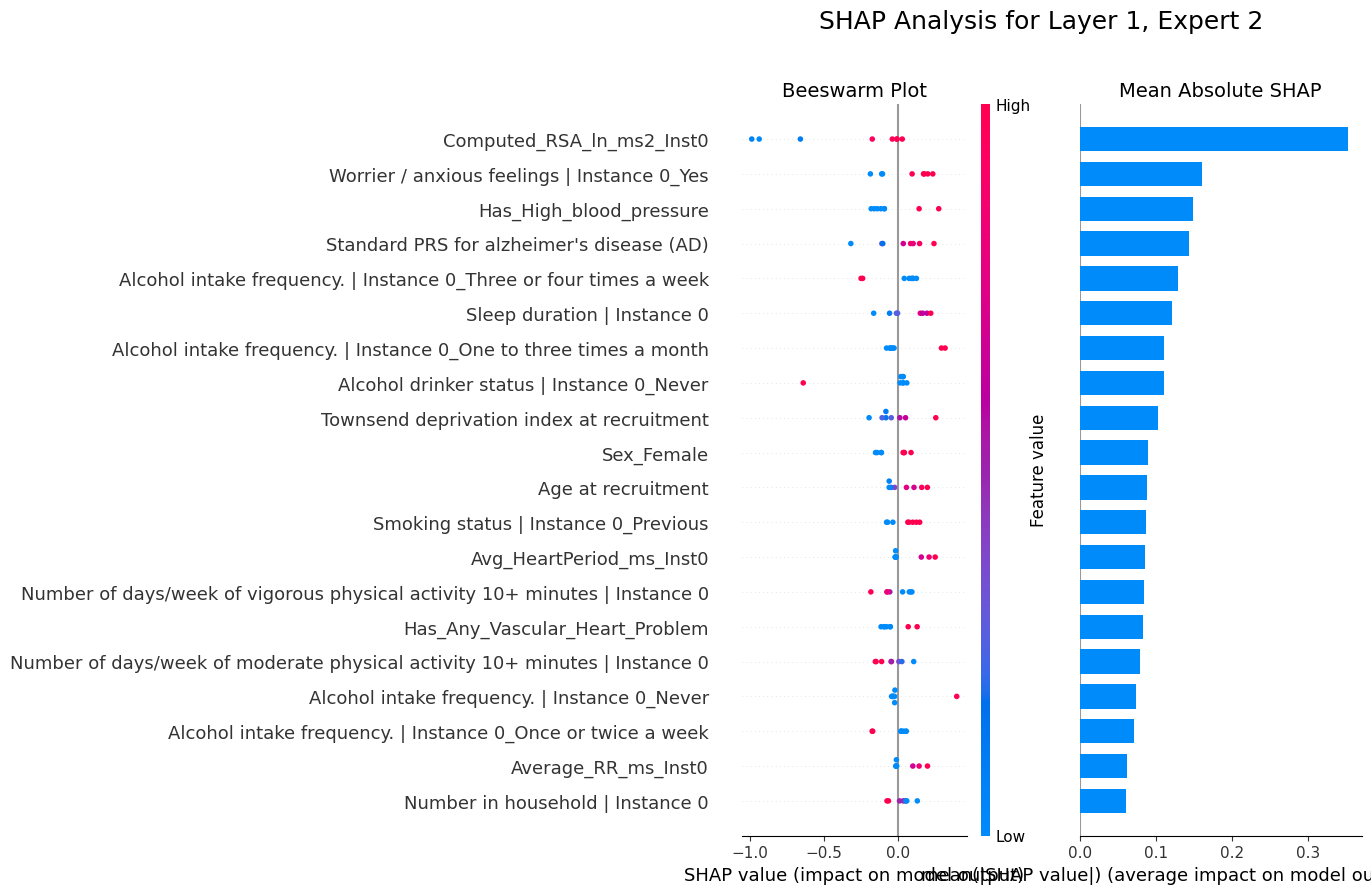


--- SHAP Analysis for 440 samples routed to Layer 1, Expert 3 ---
Generating side-by-side plots for Layer 1, Expert 3...


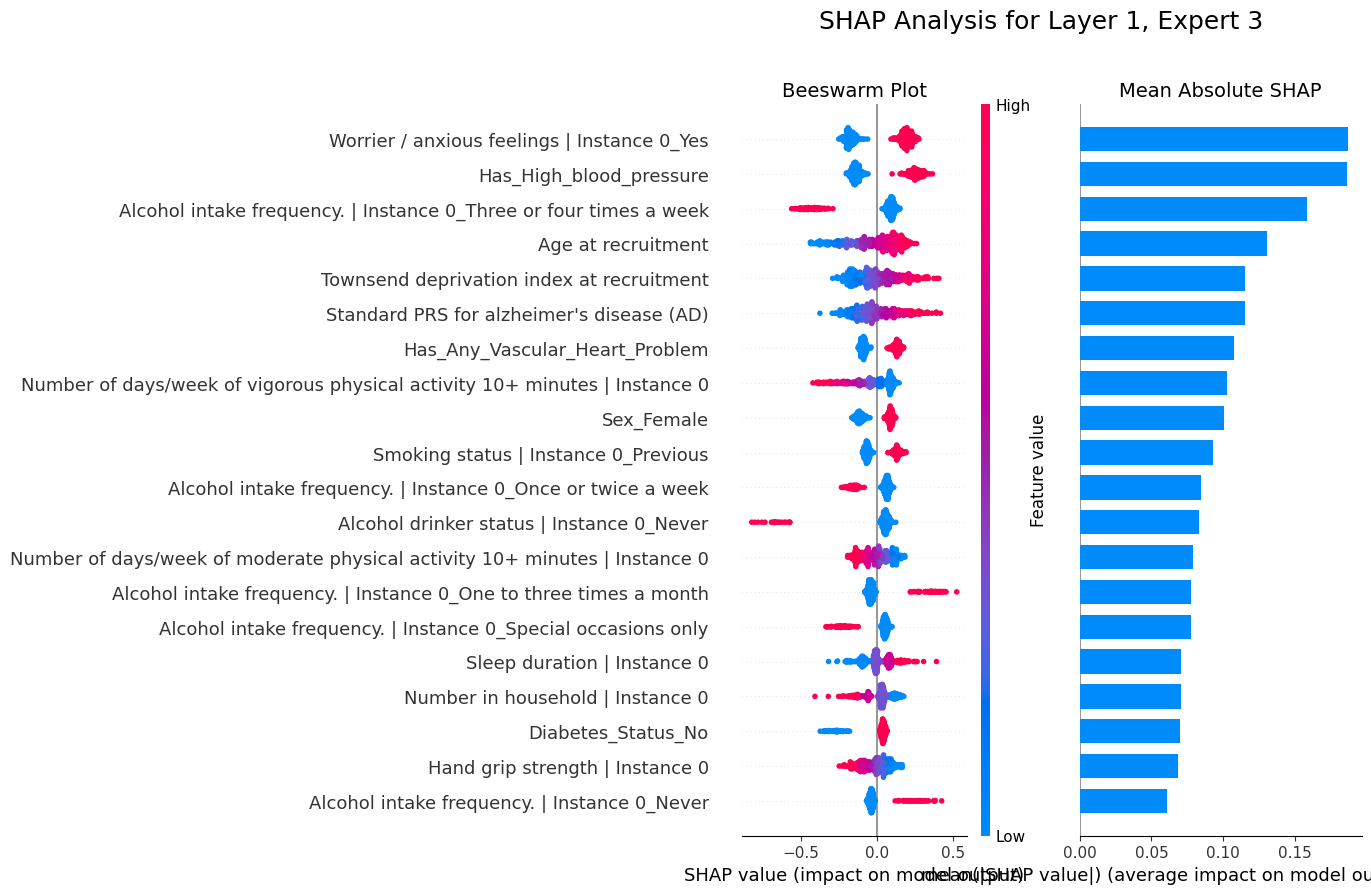


--- SHAP Analysis for 174 samples routed to Layer 2, Expert 2 ---
Generating side-by-side plots for Layer 2, Expert 2...


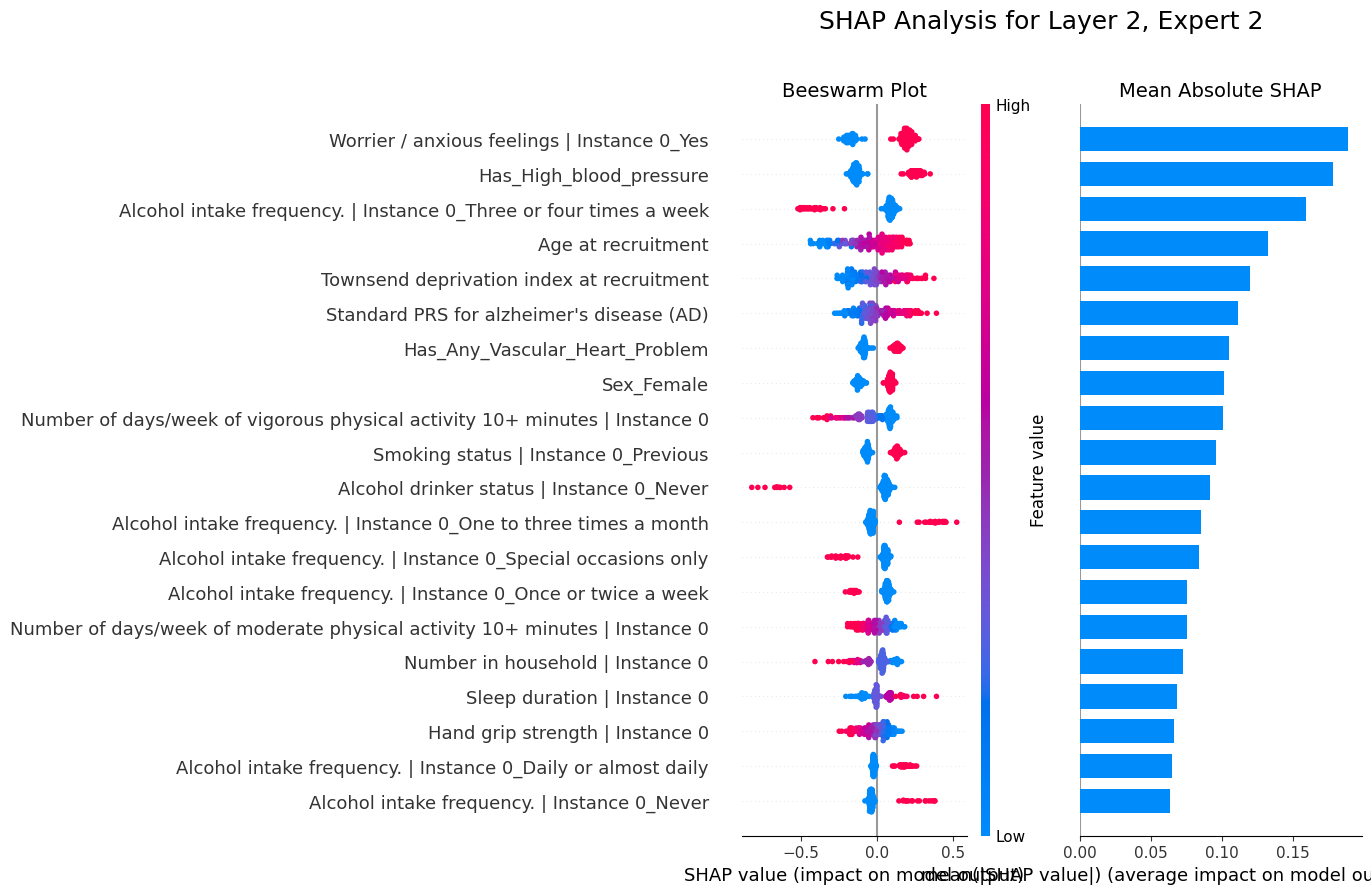


--- SHAP Analysis for 37 samples routed to Layer 2, Expert 3 ---
Generating side-by-side plots for Layer 2, Expert 3...


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


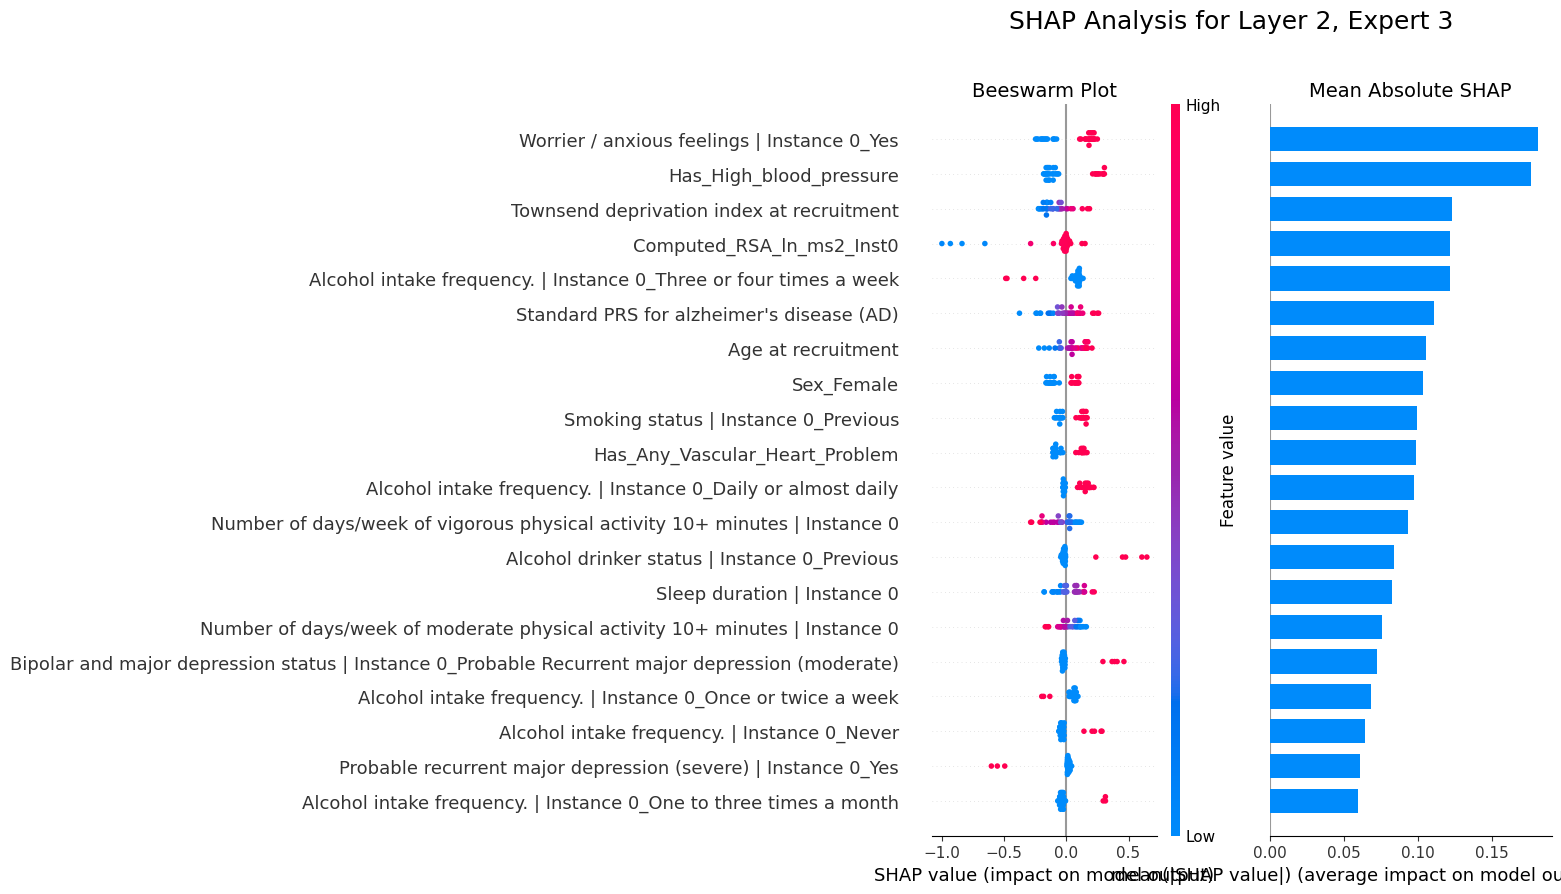


--- SHAP Analysis for 169 samples routed to Layer 3, Expert 2 ---
Generating side-by-side plots for Layer 3, Expert 2...


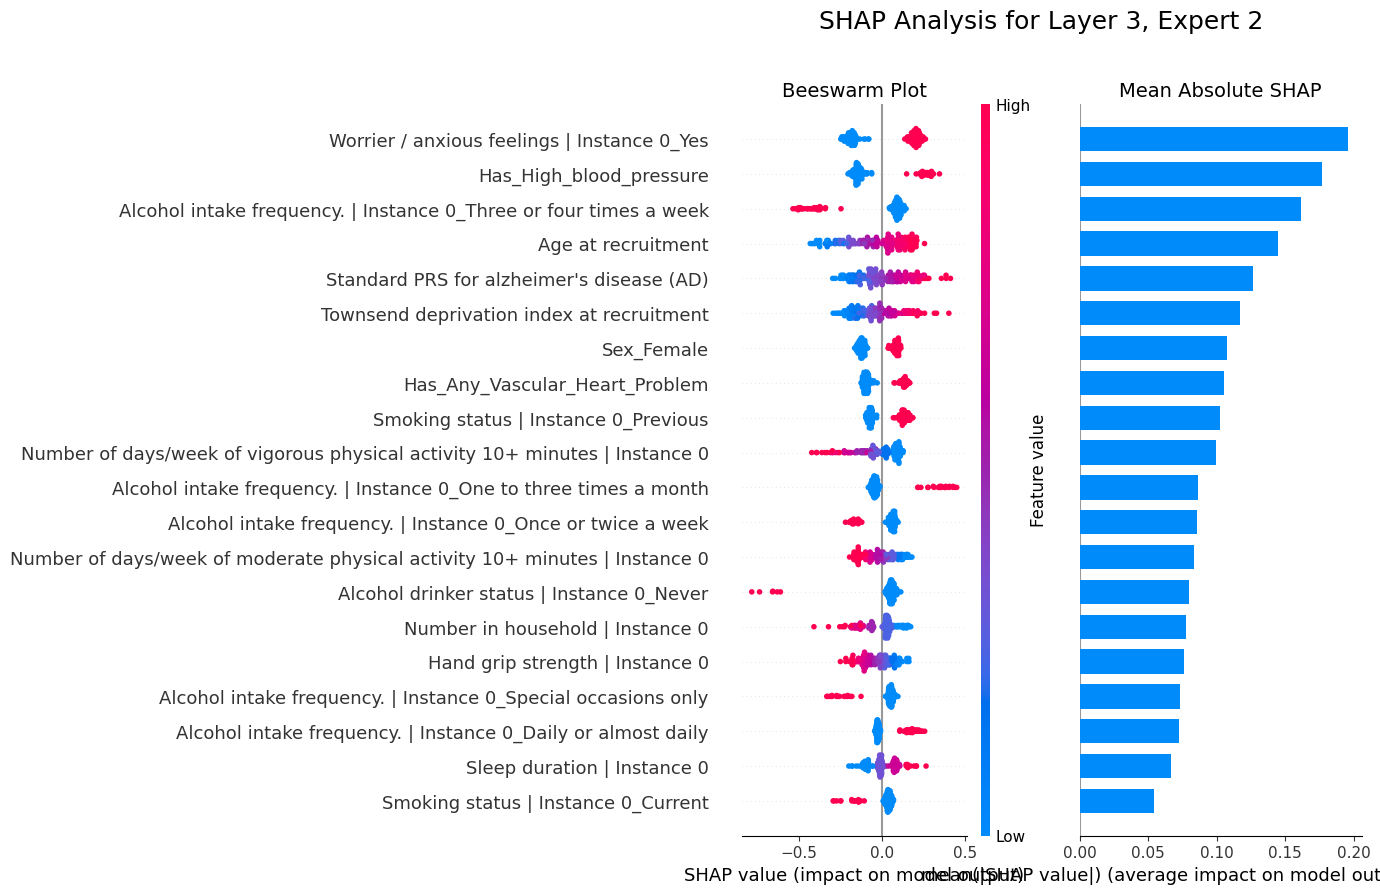


--- SHAP Analysis for 205 samples routed to Layer 3, Expert 3 ---
Generating side-by-side plots for Layer 3, Expert 3...


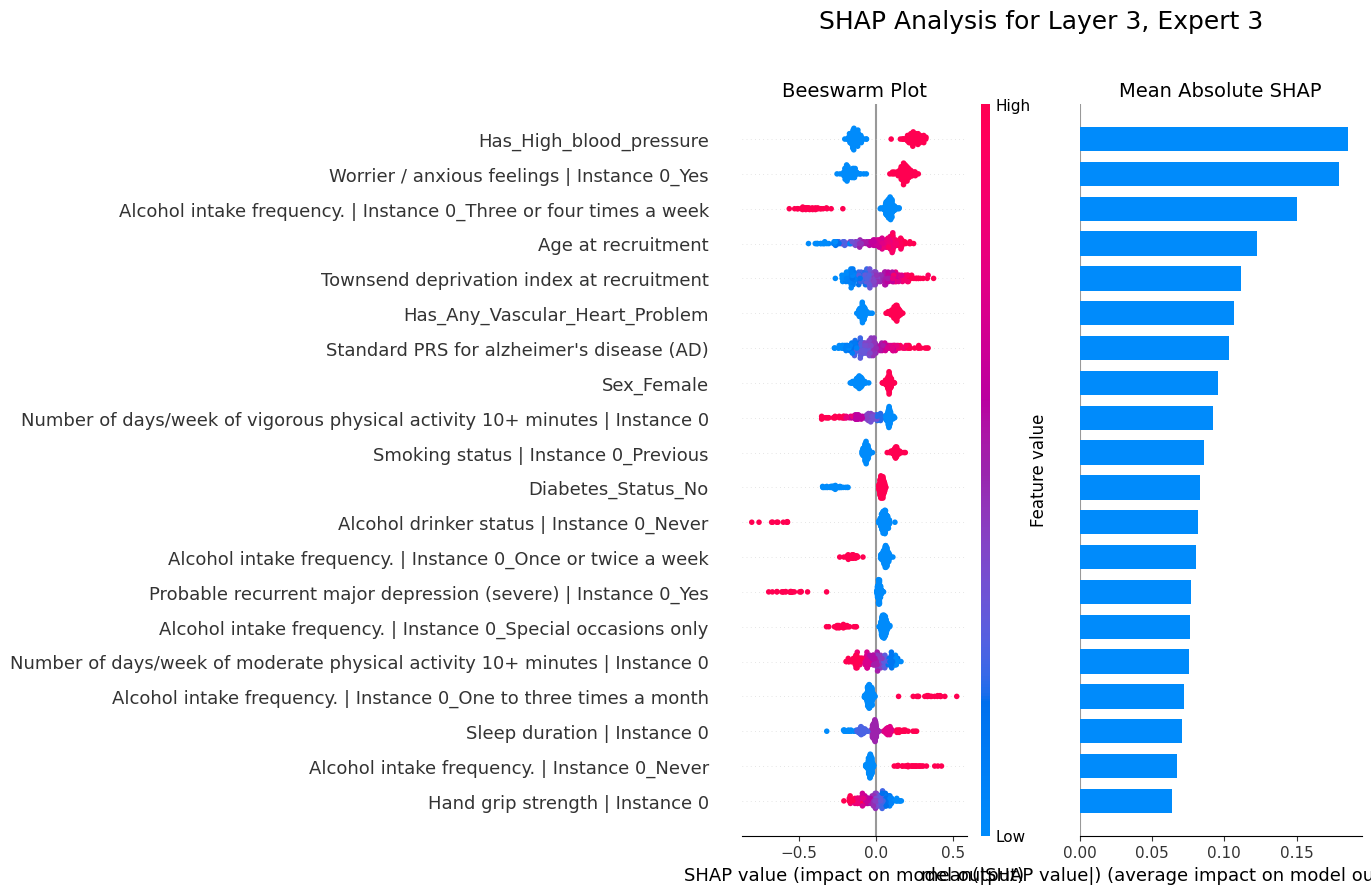

In [99]:
import shap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# ===================================================================
# SHAP Analysis of the Final, Best Model and its Experts
# ===================================================================
print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis\n" + "="*40)

# --- 1. Prepare data for SHAP ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_model.to(device)
final_model.eval()

background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

# --- 2. SHAP Analysis for the OVERALL MoP Model ---
print("\n--- Analyzing Overall MoP Model ---")
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        self.model.train()
        pred, _, _ = self.model(x.unsqueeze(1))
        return pred.squeeze(1)

shap_model_wrapper = ShapModelWrapper(final_model)
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)
shap_values = explainer.shap_values(test_tensor)

# --- PLOTTING BLOCK WITH SHARED Y-AXIS ---
print("\nGenerating side-by-side SHAP plots for the overall model...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True) 
fig.suptitle("Overall Model: SHAP Analysis", fontsize=18)

# Plot 1: Beeswarm Plot
plt.sca(axes[0]) 
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
axes[0].set_title("Beeswarm Plot ", fontsize=14)

# Plot 2: Bar Plot
plt.sca(axes[1]) 
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
axes[1].set_title("Mean Absolute SHAP ", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. Analyze what each expert focuses on ---
print("\n\n" + "="*40 + "\n🕵️ Analyzing Expert Specializations\n" + "="*40)

with torch.no_grad():
    intermediate_activations = [final_model.input_layer(test_tensor.unsqueeze(1))]
    router_weights = []
    for block in final_model.blocks:
        block_input = intermediate_activations[-1]
        _, weights, _, _, _ = block.sparse_moe.router(block_input, torch.zeros_like(block_input[:,:,0], dtype=torch.long))
        router_weights.append(weights.squeeze(1).cpu().numpy())
        block_output, _, _, _ = block(block_input, torch.zeros_like(block_input[:,:,0], dtype=torch.long))
        intermediate_activations.append(block_output)

for i, block_weights in enumerate(router_weights):
    # For this layer, find the winning expert (the one with the highest weight) for each sample
    chosen_experts_for_layer = np.argmax(block_weights, axis=1)
    
    for j in range(block_weights.shape[1]):
        if final_model.blocks[i].sparse_moe.experts[j].identity:
            continue

        samples_for_this_expert_indices = np.where(chosen_experts_for_layer == j)[0]

        # Check if any samples were routed to this expert before plotting
        if len(samples_for_this_expert_indices) == 0:
            print(f"\nNo samples were primarily routed to Layer {i+1}, Expert {j+1}. Skipping.")
            continue
        
        print(f"\n--- SHAP Analysis for {len(samples_for_this_expert_indices)} samples routed to Layer {i+1}, Expert {j+1} ---")
        
        # Use the new indices to create the data subset for SHAP
        shap_subset = shap_values[1][samples_for_this_expert_indices]
        X_test_subset = X_test_scaled[samples_for_this_expert_indices]

        print(f"Generating side-by-side plots for Layer {i+1}, Expert {j+1}...")
        fig_expert, axes_expert = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        fig_expert.suptitle(f"SHAP Analysis for Layer {i+1}, Expert {j+1}", fontsize=18)

        # Beeswarm plot
        plt.sca(axes_expert[0])
        shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="dot", show=False)
        axes_expert[0].set_title("Beeswarm Plot", fontsize=14)
        
        # Bar plot
        plt.sca(axes_expert[1])
        shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="bar", show=False)
        axes_expert[1].set_title("Mean Absolute SHAP", fontsize=14)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



🚦 Analyzing Expert Routing on Test Data

--- Routing Percentage Table (%) ---
This table shows the percentage of test samples routed to each expert in each layer.


,Expert 1,Expert 2,Expert 3
Layer 1,3.45%,1.72%,94.83%
Layer 2,54.53%,37.50%,7.97%
Layer 3,19.40%,36.42%,44.18%




--- Routing Percentage Heatmap ---


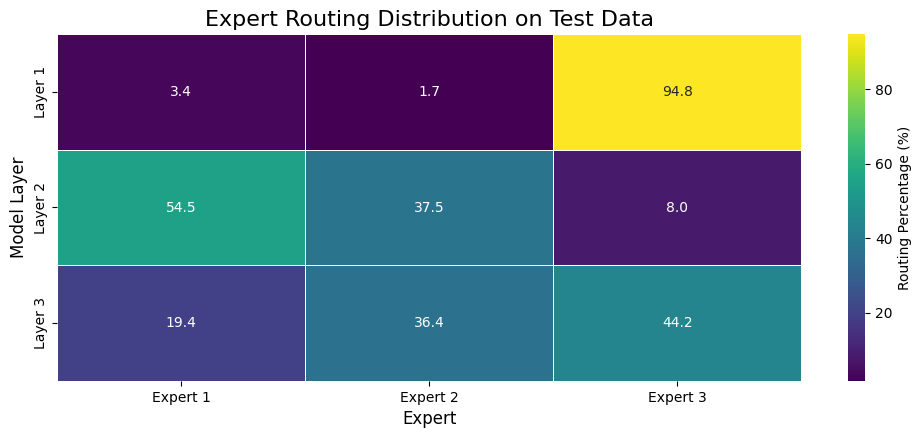

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# ===================================================================
# MoP Routing Analysis
# ===================================================================
print("\n\n" + "="*40 + "\n🚦 Analyzing Expert Routing on Test Data\n" + "="*40)

# --- 1. Process Router Weights to Calculate Percentages ---
routing_data = []
num_samples = test_tensor.shape[0]

for i, block_weights in enumerate(router_weights):
    # For each sample, find the index of the expert with the highest weight
    chosen_experts = np.argmax(block_weights, axis=1)
    
    # Count how many times each expert was chosen
    num_experts = block_weights.shape[1]
    counts = np.bincount(chosen_experts, minlength=num_experts)
    
    # Convert counts to percentages
    percentages = (counts / num_samples) * 100
    routing_data.append(percentages)

# --- 2. Create and Display the Routing Table ---
# Create column and row names for the DataFrame
num_layers = len(router_weights)
num_experts_per_layer = router_weights[0].shape[1]
layer_names = [f'Layer {i+1}' for i in range(num_layers)]
expert_names = [f'Expert {j+1}' for j in range(num_experts_per_layer)]

# Create the DataFrame
routing_df = pd.DataFrame(routing_data, index=layer_names, columns=expert_names)

print("\n--- Routing Percentage Table (%) ---")
print("This table shows the percentage of test samples routed to each expert in each layer.")
display(routing_df.style.format("{:.2f}%"))


# --- 3. Create and Display the Routing Heatmap ---
print("\n\n--- Routing Percentage Heatmap ---")
plt.figure(figsize=(12, max(4, num_layers * 1.5))) # Adjust height based on number of layers
sns.heatmap(
    routing_df, 
    annot=True,          # Show the percentage values in the cells
    fmt=".1f",           # Format values to one decimal place
    cmap="viridis",      # Use the 'viridis' color map
    linewidths=.5,       # Add thin lines between cells
    cbar_kws={'label': 'Routing Percentage (%)'} # Add a label to the color bar
)
plt.title("Expert Routing Distribution on Test Data", fontsize=16)
plt.xlabel("Expert", fontsize=12)
plt.ylabel("Model Layer", fontsize=12)
plt.show()



 📊 Calculating MoP Specialization 

--- Analyzing Layer 1 ---
Extracted feature importance vectors for 2 active experts in Layer 1.

--- Analyzing Layer 2 ---
Extracted feature importance vectors for 2 active experts in Layer 2.

--- Analyzing Layer 3 ---
Extracted feature importance vectors for 2 active experts in Layer 3.


 ✅ Final MoP Specialization Summary (Per Layer) 


,Specialization Index
Layer,
1,0.198735
2,0.038476
3,0.016049




##################################################
# Overall Model Specialization (All 6 Experts Combined)
##################################################


--- Pairwise Similarity Matrix (All Experts) ---


,L1_E2,L1_E3,L2_E2,L2_E3,L3_E2,L3_E3
L1_E2,1.0000,0.8013,0.7964,0.8719,0.8023,0.7828
L1_E3,0.8013,1.0000,0.9978,0.9639,0.9946,0.9962
L2_E2,0.7964,0.9978,1.0000,0.9615,0.9955,0.9928
L2_E3,0.8719,0.9639,0.9615,1.0000,0.9584,0.9622
L3_E2,0.8023,0.9946,0.9955,0.9584,1.0000,0.9840
L3_E3,0.7828,0.9962,0.9928,0.9622,0.9840,1.0000


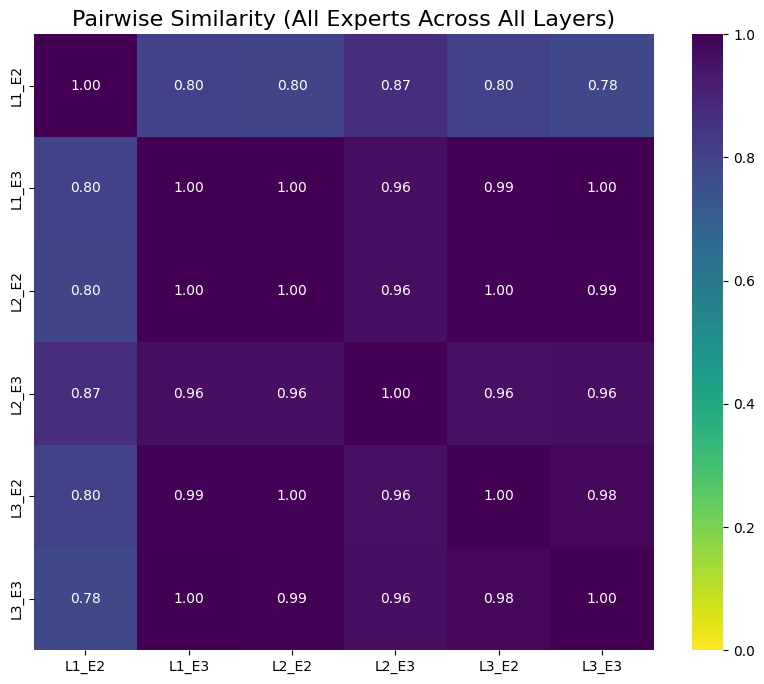


--- Overall Model Specialization Score ---
Average similarity between all experts: 0.9241
Overall Model Specialization Index: 0.0759


In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# ===================================================================
# MoP Specialization Analysis (Per-Layer and Overall)
# ===================================================================
print("\n\n" + "="*40 + "\n 📊 Calculating MoP Specialization \n" + "="*40)

try:
    
    layer_specialization_scores = []
    all_expert_vectors = {}

    # --- Step 1: Loop through each layer to perform PER-LAYER analysis ---
    for i, block_weights in enumerate(router_weights):
        layer_num = i + 1
        print(f"\n--- Analyzing Layer {layer_num} ---")
        
        layer_mean_abs_shap_vectors = {}
        num_experts = block_weights.shape[1]
        chosen_experts_for_layer = np.argmax(block_weights, axis=1)

        # --- Step 2: Extract Mean SHAP Vector for Each Expert in this Layer ---
        for j in range(num_experts):
            if final_model.blocks[i].sparse_moe.experts[j].identity:
                continue

            samples_for_this_expert_indices = np.where(chosen_experts_for_layer == j)[0]
            if len(samples_for_this_expert_indices) == 0:
                continue
            
            shap_subset = shap_values[1][samples_for_this_expert_indices]
            mean_vector = np.abs(shap_subset).mean(axis=0)
            
            # Store the vector for the per-layer calculation
            layer_mean_abs_shap_vectors[f'Expert {j+1}'] = mean_vector
            all_expert_vectors[f'L{layer_num}_E{j+1}'] = mean_vector

        print(f"Extracted feature importance vectors for {len(layer_mean_abs_shap_vectors)} active experts in Layer {layer_num}.")

        # --- Step 3: Compute the Specialization Index for this Layer ---
        if len(layer_mean_abs_shap_vectors) < 2:
            print(f"Cannot calculate specialization for Layer {layer_num} with less than two active experts.")
            layer_specialization_scores.append({'Layer': layer_num, 'Specialization Index': np.nan})
            continue
        
        shap_matrix = np.array(list(layer_mean_abs_shap_vectors.values()))
        similarity_matrix = cosine_similarity(shap_matrix)
        indices = np.triu_indices(shap_matrix.shape[0], k=1)
        off_diagonal_values = similarity_matrix[indices]
        mean_similarity = np.mean(off_diagonal_values)
        specialization_index = 1 - mean_similarity
        layer_specialization_scores.append({'Layer': layer_num, 'Specialization Index': specialization_index})

    # --- Step 4: Display Final PER-LAYER Summary Table ---
    if layer_specialization_scores:
        summary_df = pd.DataFrame(layer_specialization_scores)
        print("\n\n" + "="*40 + "\n ✅ Final MoP Specialization Summary (Per Layer) \n" + "="*40)
        display(summary_df.set_index('Layer'))
    
    # --- Step 5: Calculate and Display OVERALL Specialization for All Experts ---
    print("\n\n" + "#"*50)
    print("# Overall Model Specialization (All 6 Experts Combined)")
    print("#"*50)

    if len(all_expert_vectors) < 2:
        print("\nCannot calculate overall specialization with less than two active experts across all layers.")
    else:
        expert_names = list(all_expert_vectors.keys())
        shap_matrix = np.array(list(all_expert_vectors.values()))
        
        similarity_matrix = cosine_similarity(shap_matrix)
        similarity_df = pd.DataFrame(similarity_matrix, index=expert_names, columns=expert_names)

        print("\n\n--- Pairwise Similarity Matrix (All Experts) ---")
        display(similarity_df.style.format("{:.4f}").background_gradient(cmap='viridis_r', vmin=0, vmax=1))

        plt.figure(figsize=(10, 8))
        sns.heatmap(similarity_df, annot=True, cmap='viridis_r', vmin=0, vmax=1, fmt=".2f")
        plt.title('Pairwise Similarity (All Experts Across All Layers)', fontsize=16)
        plt.show()

        indices = np.triu_indices(shap_matrix.shape[0], k=1)
        off_diagonal_values = similarity_matrix[indices]
        mean_similarity = np.mean(off_diagonal_values)
        specialization_index = 1 - mean_similarity

        print(f"\n--- Overall Model Specialization Score ---")
        print(f"Average similarity between all experts: {mean_similarity:.4f}")
        print(f"Overall Model Specialization Index: {specialization_index:.4f}")

except NameError:
    print("Error: `shap_values` or `router_weights` not found. Please run the main MoP SHAP analysis block first.")